This notebook was prepared by:

Alex Ferrante (af3913@nyu.edu)

Vinicius Moreira (vgm236@nyu.edu)

Graduate School of Arts and Sciences (GSAS) at New York University (NYU)

December 2021

# Labor Market In Times Of COVID-19 

## 1. Introduction

Within the United States, as well as across the World, the COVID-19 pandemic created economic dismay and forced millions of individuals out of the labor force. Given that the virus was not restricted by geography, all regions of the U.S felt the economic instability. Throughout the pandemic, states revealed their preference for risk by either implementing more conservative restrictions, or contrary, not imposing restrictions at all. 

At the same time, different states and countries implemented different policies to smooth the effects of the crisis in the population, particularly through stimulus checks and unemployment benefits. From the economic investigation point of view, these policies provided the opportunity to understand how the implementation and extirpation of stimulus programs affected states economic recovery. 

In an effort to further investigate the severity in which COVID-19 the labor market, our project will first compare the evolution of the US labor market in this and past recessions. In particular, we look into the behavior of the unemployment rate and labor force participation not only at the national level but also at the regional and state-level during periods denoted as pre-COVID, intra-COVID, and post-COVID. 

By breaking the study into these three distinct time periods, it will be possible to interpret the direct effects COVID had on labor markets. Next, we will test to detect if the announcement and expiration of Pandemic Unemployment Assistance (PUA) transfers from local governments had an effect on the behavior of workers, particularly on the labor force participation.

## 2. Pulling and Staging the Data

First, let's import the necessary packages to download the data, work with it, create plots, and run our analyses.

In [1]:
# FOR IMPORTING DATA
import requests
import json
import csv
import datetime

# FOR API
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
from typing import List, Union, Optional

# FOR CHARTS
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
import matplotlib.patches as patches
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import datetime as dt
import matplotlib.dates as mdates

# OTHER DATA TOOLS
import math
%matplotlib inline

### 2.1 Pulling Data From Bureau of Labor Statistics (BLS)

Given that the focus will be on U.S labor force participation and unemployment rate, we'll incorporate data collected from API of the Bureau of Labor Statistics (https://www.bls.gov/lau/).

We first set up our API Key to be used for BLS, which is saved on a separate .txt file for security purposes (but we will leave open for grading).

In [2]:
txt_file = open("BLS_API_KEY.txt")
apikey = txt_file.read()

Next, using the knowledge learned in class, we copy and adapt a function to download data from the BLS API:

In [3]:
def request_for_series(
        series_ids: List[str], 
        startyear: Union[int,str], 
        endyear: Union[int,str],
        apikey:Optional[str]=None,
    ):
    """
    Request data for all ``series_ids`` between ``startyear`` and ``endyear``
    
    Parameters
    ----------
    series_ids: List[str]
        A list of all BLS series IDs for which to request data
    
    startyear, endyear: Union[int,str]
        Starting and ending years for period of data. All intervals between
        these two years (inclusive) will be reported
    
    apikey: Optional[str]
        A registration or API key to enable more extensive use of the
        api and more detailed results
    
    Returns
    -------
    responses: List[requests.Response]
        A list of `Response` objects from the requests library
    
    Notes
    -----
    The BLS API only allows 25 series to be requested in a single call to the API
    This function allows an arbitrary number of series. The function first checks how 
    many series_ids are requested, and then makes two recursive calls to this function:
    
    (1) the first 25 series IDs are fetched and 
    (2) the rest of the series ids. 
    
    If the second request contains more than 25 series, another split is made and a pair of 
    recursive function calls are issued.
    
    Also note that the response objects from ``requests`` are not processed or validated
    in any way -- this is up to the caller of this routine.
    
    Finally, if an apikey is given, then a catalog of series metadata will be requested
    and returned from this function. This is necessary for getting the metadata DataFrame
    from the functions ``make_dfs_from_series``, ``unpack_response``, and 
    ``unpack_all_responses`` functions below.
    """
    n_series = len(series_ids)
    if n_series > 25:  #for more than 25, you work on this
        parts = []
        # make common keyword arguments so we don't have to type twice below
        kw = dict(endyear=endyear, startyear=startyear, apikey=apikey)
        parts.extend(request_for_series(series_ids[:25], **kw))
        parts.extend(request_for_series(series_ids[25:], **kw))
        return parts
    else:
        headers = {'Content-type': 'application/json'}
        params = {
            "seriesid": series_ids, 
            "startyear":startyear, 
            "endyear": endyear,
        }
        if apikey is not None:
            params["catalog"] = True
            params["registrationkey"] = apikey
        
        # convert params dictionary to json string
        data = json.dumps(params)
        p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
        return [p]

The function below is used to validate the search through the website (i.e. to see if it works).

In [4]:
def check_response(res: requests.Response):
    """
    Check a response from the BLS API for success
    
    Parameters
    ----------
    res: requests.Response
        The requests object returned from iteracting with BLS API
        
    Notes
    -----
    Right now we just check for success at the http protocol level
    and don't do any checking specific to the BLS api
    """
    code = res.status_code
    if code > 299:
        raise ValueError(f"Response error with code {code}")

This function is to transfer the data into dataframes.

In [5]:
def make_dfs_from_series(series_results):
    """
    Unpack a series response object into data and metadata pandas objects
    
    Parameters
    ----------
    series_results: dict
        A dictionary returned from the `timeseries/data` endpoint of the
        BLS api. An example object for this parameter would be found at
        ``res.json()["Results"]["series"][0]`` where ``res`` is the 
        ``requests.Response`` obtained from interacting with the API endpoint.
    
    Returns
    -------
    data: pd.DataFrame
        A pandas DataFrame containing the actual observations of the data series
    
    metadata: Optional[pd.Series]
        If the ``"catgalog"`` key exists in ``series_results``, then ``metadata``
        is a pandas Series containing the catalog information. If ``"catalog"``
        is found, then this is None    
    """
    # Extract series ID and store as a variable
    series_id = series_results["seriesID"]
    
    # Next, we create a panda dataframe, reading a list of dict
    # We attach ID as an additional column
    data = pd.DataFrame(series_results["data"]).assign(series_id=series_id)
    
    # If catalog was attached, we create a series
    # If not, we don't
    if "catalog" in series_results:
        metadata = pd.Series(series_results["catalog"])
    else:
        metadata = None
    
    return data, metadata

These two functions will unpack the data.

In [6]:
def unpack_response(res: requests.Response):
    """
    Unpack the response for requesting one or more timeseries 
    from the BLS api
    
    Parameters
    ----------
    res: requests.Response
        The object returned from interacting with the ``timeseries/data``
        BLS API endpoint via the reuqests library
    
    Returns
    -------
    datasets: List[Tuple[pd.DataFrame, pd.Series]]
        For each BLS series contained in ``res``, a tuple with the 
        timeseries observations and series metadata will be returned.
        The observations are a pandas DataFrame and the metadata is a
        pandas Series. These pairs of (data, metadata) are returned
        in a list
    
    See Also
    --------
    See ``make_dfs_from_series`` for more information on content
    of output.
    """
    # Compute the json form of our response
    js = res.json()
    # Now we map the results and series as above when we created data and meta
    
    return list(map(make_dfs_from_series, js["Results"]["series"]))


def unpack_all_responses(all_res: List[requests.Response]):
    """
    Given a list of responses from the BLS API, extract and 
    return all data and metadata
    
    Parameters
    ----------
    all_res: List[requests.Response])
        Each item in this list is the result of using ``requests`` to 
        fetch data from ``timeseries/data`` endpoint of the BLS API.
        
    Returns
    -------
    data: pd.DataFrame
        A pandas DataFrame containing all timeseries observations included
        in any of the responses in ``all_res``
    
    metadata: pd.DataFrame
        Detailed metadata about each series, if such metadata exists in the
        response objects
    
    See Also
    --------
    See ``unpack_response`` and ``make_dfs_from_series`` functions
        
    """
    # Make unpacked an empty list
    unpacked = []
    
    # Then use a for function to unpack all of them (list)
    for res in all_res:
        unpacked.extend(unpack_response(res))
    
    data_dfs, metadata_series = list(zip(*unpacked))
    
    # Stack all data one on the top of the other
    data = pd.concat(data_dfs, ignore_index=True)
    
    # Add the metadata and stack them as columns
    metadata = pd.concat([x for x in metadata_series if x is not None], axis=1).T
    
    return data, metadata

Now, let's find all the series of interest.

If it ends with:

3. Seasonally adjustment unemployment rate. 
4. Seasonally adjusted unemployment level
5. Seasonally adjusted employment level
6. Seasonally adjusted labor force level
7. Seasonally adjusted employment-population ratio
8. Seasonally adjusted labor force participation ratio

We will use only 3 and 8 in our analysis. The first two numbers refer to the state from which the data is extracted.

Note that the first two IDs refer to the national unemployment rate and labor force participation, respectively.

In [7]:
series_ids = [
    "LNS14000000",
    "LNS11300000",
    "LASST010000000000003", 
    "LASST010000000000008", 
    "LASST020000000000003", 
    "LASST020000000000008", 
    "LASST030000000000003",
    "LASST030000000000008", 
    "LASST040000000000003",
    "LASST040000000000008", 
    "LASST050000000000003", 
    "LASST050000000000008", 
    "LASST060000000000003", 
    "LASST060000000000008", 
    "LASST070000000000003", 
    "LASST070000000000008", 
    "LASST080000000000003", 
    "LASST080000000000008", 
    "LASST090000000000003",
    "LASST090000000000008", 
    "LASST100000000000003",
    "LASST100000000000008", 
    "LASST110000000000003", 
    "LASST110000000000008", 
    "LASST120000000000003", 
    "LASST120000000000008", 
    "LASST130000000000003", 
    "LASST130000000000008", 
    "LASST140000000000003", 
    "LASST140000000000008", 
    "LASST150000000000003", 
    "LASST150000000000008", 
    "LASST160000000000003", 
    "LASST160000000000008", 
    "LASST170000000000003", 
    "LASST170000000000008", 
    "LASST180000000000003", 
    "LASST180000000000008", 
    "LASST190000000000003", 
    "LASST190000000000008",
    "LASST200000000000003", 
    "LASST200000000000008", 
    "LASST210000000000003", 
    "LASST210000000000008", 
    "LASST220000000000003", 
    "LASST220000000000008", 
    "LASST230000000000003", 
    "LASST230000000000008", 
    "LASST240000000000003", 
    "LASST240000000000008", 
    "LASST250000000000003", 
    "LASST250000000000008", 
    "LASST260000000000003", 
    "LASST260000000000008", 
    "LASST270000000000003", 
    "LASST270000000000008", 
    "LASST280000000000003", 
    "LASST280000000000008", 
    "LASST290000000000003", 
    "LASST290000000000008", 
    "LASST300000000000003", 
    "LASST300000000000008", 
    "LASST310000000000003",
    "LASST310000000000008", 
    "LASST320000000000003", 
    "LASST320000000000008", 
    "LASST330000000000003", 
    "LASST330000000000008",
    "LASST340000000000003", 
    "LASST340000000000008", 
    "LASST350000000000003",
    "LASST350000000000008",  
    "LASST360000000000003", 
    "LASST360000000000008", 
    "LASST370000000000003", 
    "LASST370000000000008", 
    "LASST380000000000003", 
    "LASST380000000000008", 
    "LASST390000000000003", 
    "LASST390000000000008", 
    "LASST400000000000003", 
    "LASST400000000000008",    
    "LASST410000000000003", 
    "LASST410000000000008", 
    "LASST420000000000003", 
    "LASST420000000000008", 
    "LASST430000000000003", 
    "LASST430000000000008", 
    "LASST440000000000003", 
    "LASST440000000000008", 
    "LASST450000000000003", 
    "LASST450000000000008", 
    "LASST460000000000003", 
    "LASST460000000000008", 
    "LASST470000000000003", 
    "LASST470000000000008", 
    "LASST480000000000003", 
    "LASST480000000000008", 
    "LASST490000000000003", 
    "LASST490000000000008", 
    "LASST500000000000003", 
    "LASST500000000000008", 
    "LASST510000000000003", 
    "LASST510000000000008",
    "LASST520000000000003", 
    "LASST520000000000008",
    "LASST530000000000003",
    "LASST530000000000008",
    "LASST540000000000003", 
    "LASST540000000000008", 
    "LASST550000000000003", 
    "LASST550000000000008",     
    "LASST560000000000003", 
    "LASST560000000000008", 
]

# Make requests, get responses
responses1 = request_for_series(series_ids, "1976", "1995", apikey=apikey)

# Validate the responses
[check_response(r) for r in responses1]

# Extract data and metadata from responses
df1, metadata1 = unpack_all_responses(responses1)

# Pull data for date range: 1996 - 2015
responses2 = request_for_series(series_ids, "1996", "2015", apikey=apikey)
df2, metadata2 = unpack_all_responses(responses2)

# Pull data for date range: 2016 - 2021
responses3 = request_for_series(series_ids, "2016", "2021", apikey=apikey)
df3, metadata3 = unpack_all_responses(responses3)

### 2.2 Incorporating Data Related to State PUA

One of the objectives of this project is to understand whether the announcement date and expiration date of PUA payments effects the rate at which individuals rejoined the labor force.

With this in mind, we collected and will now incorporate data on the dates when states announced (announce_ui) that Pandemic Unemployment Assistance (PUA) will expire in addition to the actual date when PUA expired (expired_ui). 

In [8]:
announce_url = "https://raw.githubusercontent.com/vgm236/ferrante_moreira_data_project/main/Data/announced_dates_ui_expiration.csv"
announce_ui = pd.read_csv(announce_url)

expired_url = "https://raw.githubusercontent.com/vgm236/ferrante_moreira_data_project/main/Data/effective_dates_ui_expiration.csv"
expired_ui = pd.read_csv(expired_url)

## 3. Preparing Data for Analysis 

This is the longest part of the project. We combine the data, making sure we are consistent across the board. We pass some checks and then separate the data as it fits.

Since the data for state unemployment rate and labor force participation was pulled in three groups (1976-1995, 1996-2015, 2016-2021), we will now combine to create one dataframe for unemployment and labor force participation values and one for metadata.

In [9]:
# Create single dataframe for df1, df2, and df3
df = pd.concat([df1, df2, df3])

# Sort years in ascending order 
df = df.sort_values(by=["year"]) 

# Create single dataframe for metadata1, metadata2, metadata3
metadata = pd.concat([metadata1, metadata2, metadata3])

# Show the years included
print(df["year"].unique())

['1976' '1977' '1978' '1979' '1980' '1981' '1982' '1983' '1984' '1985'
 '1986' '1987' '1988' '1989' '1990' '1991' '1992' '1993' '1994' '1995'
 '1996' '1997' '1998' '1999' '2000' '2001' '2002' '2003' '2004' '2005'
 '2006' '2007' '2008' '2009' '2010' '2011' '2012' '2013' '2014' '2015'
 '2016' '2017' '2018' '2019' '2020' '2021']


Since the Metadata dataframe is composed of both unemployment rate and labor force participation, we will separate accordingly to make future convenience.

In [10]:
# Dataframe including only measure unemployment rate on a national level
df_nat_ur = metadata.query("series_title == '(Seas) Unemployment Rate'")

# Dataframe including only measure labor force participation on a national level
df_nat_lfp = metadata.query("series_title == '(Seas) Labor Force Participation Rate'")

# Dataframe including only measure data types for unemployment rate
df_ur = metadata.query("measure_data_type == 'unemployment rate'")

# Dataframe including only measure data types for labor force participation
df_lfp = metadata.query("measure_data_type == 'labor force participation rate'")

Now that we have the dataframes separated by unemployment rate and labor force participation, we can map values from the our general dataframe (df) to get the IDs for the dataframe with unemployment rates only (df_ur) and the same IDS for the labor force participation (df_lfp) dataframe only.

In [11]:
# Merge on series id on a national level, first by unemployment rate and then by labor force participation
df_nat_ur_values = df_nat_ur.merge(df, on="series_id", how="left")
df_nat_lfp_values = df_nat_lfp.merge(df, on="series_id", how="left")

# Merge df on df_ur by series id to get each states unemployment rate
df_ur_values = df_ur.merge(df, on="series_id", how="left")

# Merge df on df_lfp by series id to get each states labor force participation rate
df_lfp_values = df_lfp.merge(df, on="series_id", how="left")

In [12]:
# change "area" values to abbrevations to allow for merging ui_dates  
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "District of Columbia" : "DC",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY"
}

df_ur_values["area"] = df_ur_values["area"].replace(us_state_to_abbrev)

df_lfp_values["area"] = df_lfp_values["area"].replace(us_state_to_abbrev)

In [13]:
# Data Preparation for analyses
pd.options.mode.chained_assignment = None

# Create smaller DataFrames for UR and LFP with only necessary columns
df_nat_ur_small = df_nat_ur_values[["area", "year", "period", "value"]]
df_nat_lfp_small = df_nat_lfp_values[["area", "year", "period", "value"]]

df_ur_small = df_ur_values[["area", "year", "period", "value"]]
df_lfp_small = df_lfp_values[["area", "year", "period", "value"]]

# Remove the M from period to create an integer for the month, then create a new column which is the date (Year-Month-Day)
df_nat_ur_small["month"] = df_nat_ur_small["period"].str.strip("M").astype(int) 
df_nat_ur_small["date"] = pd.to_datetime(df_nat_ur_small[["year", "month"]].assign(DAY=1))

df_nat_lfp_small["month"] = df_nat_lfp_small["period"].str.strip("M").astype(int) 
df_nat_lfp_small["date"] = pd.to_datetime(df_nat_lfp_small[["year", "month"]].assign(DAY=1))

df_ur_small["month"] = df_ur_small["period"].str.strip("M").astype(int) 
df_ur_small["date"] = pd.to_datetime(df_ur_small[["year", "month"]].assign(DAY=1))

df_lfp_small["month"] = df_lfp_small["period"].str.strip("M").astype(int)
df_lfp_small["date"] = pd.to_datetime(df_lfp_small[["year", "month"]].assign(DAY=1))

# Re-label values in both DataFrames so it is clear which refers to UR and LFP once merged
ur_value_name = {"value" : "unemployment_rate"}
lfp_value_name = {"value" : "labor_force_participation"}

df_nat_ur_small = df_nat_ur_small.rename(columns=ur_value_name)
df_nat_lfp_small = df_nat_lfp_small.rename(columns=lfp_value_name)

df_ur_small = df_ur_small.rename(columns=ur_value_name)
df_lfp_small = df_lfp_small.rename(columns=lfp_value_name)

# Drop uncessary columns
df_nat_ur_small = df_nat_ur_small[["area", "unemployment_rate", "date"]]
df_nat_lfp_small = df_nat_lfp_small[["area", "labor_force_participation", "date"]]

df_ur_small = df_ur_small[["area", "unemployment_rate", "date"]]
df_lfp_small = df_lfp_small[["area", "labor_force_participation", "date"]]

# Merge the two Dataframe on area and year
df_nat_ur_lfp = df_nat_ur_small.merge(
    df_nat_lfp_small, how='left', 
    left_on=['area', 'date'], 
    right_on=['area', 'date']
    ).drop_duplicates(subset=["area", "date"])

df_ur_lfp = df_ur_small.merge(
    df_lfp_small, how='left', 
    left_on=['area', 'date'], 
    right_on=['area', 'date']
    ).drop_duplicates(subset=["area", "date"])


# Turn UR and LFP values to float 
df_nat_ur_lfp["unemployment_rate"] = df_nat_ur_lfp["unemployment_rate"].astype(float)
df_nat_ur_lfp["labor_force_participation"] = df_nat_ur_lfp["labor_force_participation"].astype(float)

df_ur_lfp["unemployment_rate"] = df_ur_lfp["unemployment_rate"].astype(float)
df_ur_lfp["labor_force_participation"] = df_ur_lfp["labor_force_participation"].astype(float)

# Reshape data for analyses
df_ur_lfp = df_ur_lfp.pivot(
    index="date", 
    columns="area", 
    values=["unemployment_rate", "labor_force_participation"])

# Drop remaining "area from national data" --> the previous steps we kept the same to assure consistency on the methods
# Then index by date
df_nat_ur_lfp = df_nat_ur_lfp[["unemployment_rate", "date", "labor_force_participation"]]

df_nat_ur_lfp = df_nat_ur_lfp.set_index('date')
df_nat_ur_lfp = df_nat_ur_lfp.sort_index()

After all those changes and checks, let's see how our data looks like.

First, we show the national-level dataframe. Then, we show the state-level dataframe.

In [14]:
#National level data frame
df_nat_ur_lfp.head(8)

unemployment_rate  labor_force_participation
date                                                    
1976-01-01                7.9                       61.3
1976-02-01                7.7                       61.3
1976-03-01                7.6                       61.3
1976-04-01                7.7                       61.6
1976-05-01                7.4                       61.5
1976-06-01                7.6                       61.5
1976-07-01                7.8                       61.8
1976-08-01                7.8                       61.8

In [15]:
#State level dataframe
df_ur_lfp.head(8)

unemployment_rate                                                \
area                      AK   AL   AR    AZ   CA   CO   CT   DC   DE   FL   
date                                                                         
1976-01-01               7.1  6.6  7.3  10.2  9.2  5.8  9.8  8.7  8.0  9.7   
1976-02-01               7.1  6.6  7.3  10.2  9.2  5.7  9.8  8.7  8.0  9.7   
1976-03-01               7.0  6.6  7.3  10.1  9.1  5.7  9.8  8.6  8.0  9.6   
1976-04-01               6.9  6.5  7.2  10.0  9.1  5.6  9.6  8.5  8.1  9.5   
1976-05-01               6.9  6.4  7.1   9.8  9.0  5.6  9.4  8.4  8.3  9.3   
1976-06-01               7.1  6.5  6.9   9.7  9.0  5.6  9.3  8.3  8.6  9.2   
1976-07-01               7.3  6.6  6.8   9.7  9.0  5.8  9.1  8.4  8.8  9.1   
1976-08-01               7.6  6.7  6.7   9.6  9.1  5.9  9.0  8.5  8.9  9.1   

            ... labor_force_participation                                      \
area        ...                        SD    TN    TX    UT    VA    VT    WA   
date        ...                                                                 
1976-01-01  ...                      64.6  59.6  63.8  62.8  65.9  63.6  60.9   
1976-02-01  ...                      64.4  59.4  63.5  62.6  65.8  63.4  60.7   
1976-03-01  ...                      64.4  59.3  63.4  62.5  65.6  63.2  60.6   
1976-04-01  ...                      64.3  59.3  63.5  62.5  65.5  63.5  60.6   
1976-05-01  ...                      64.3  59.4  63.6  62.6  65.4  63.6  60.7   
1976-06-01  ...                      64.5  59.5  63.8  62.8  65.4  63.8  61.0   
1976-07-01  ...                      64.6  59.7  63.9  63.0  65.3  63.8  61.4   
1976-08-01  ...                      64.7  59.9  63.9  63.0  65.3  63.7  61.7   

                              
area          WI    WV    WY  
date                          
1976-01-01  65.6  52.5  65.3  
1976-02-01  65.5  52.4  64.9  
1976-03-01  65.4  52.3  64.7  
1976-04-01  65.4  52.3  64.9  
1976-05-01  65.5  52.2  65.2  
1976-06-01  65.6  52.0  65.5  
1976-07-01  65.7  51.8  65.8  
1976-08-01  65.8  51.5  65.9  

[8 rows x 102 columns]

Now, we also put the announcement and expiration dates of the Pandemic Unemployment Assistance (PUA) into dataframes.

Note that some states did not announce an end yet.

In [16]:
# merge unemployment announcement date and expiration date to single dataframe 
ui_dates = announce_ui.merge(expired_ui, on="state_abrev", how="left")

# change to datetime 
ui_dates["effe_date"] = pd.to_datetime(ui_dates["effe_date"])
ui_dates["annc_date"] = pd.to_datetime(ui_dates["annc_date"])

# change state_abrev to area for future merging simplicity
state = {"state_abrev" : "area"}
ui_dates = ui_dates.rename(columns=state)

#Some states didn't have the end of this policy thus far
ui_dates.head()

area  annc_date  effe_date
0   AK 2021-05-14 2021-06-12
1   AL 2021-05-10 2021-06-19
2   AR 2021-05-07 2021-06-26
3   AZ 2021-05-13 2021-07-10
4   CA        NaT        NaT

## 4. The Historic Fall in Participation and The Unprecedented COVID-19 Crisis

First, we show the history of unemployment rate and participation rates.

We see that the participation rates have been almost monotonically decreasing since the beginning of the 2000s. So did the unemployment rate.

The COVID-19 crisis seems to have exacerbated the trend on participation, at the same time that the rise and fall of the unemployment rate as unprecedentedly fast. 

Text(0.5, 1.0, 'Unemployment and Participation rates')

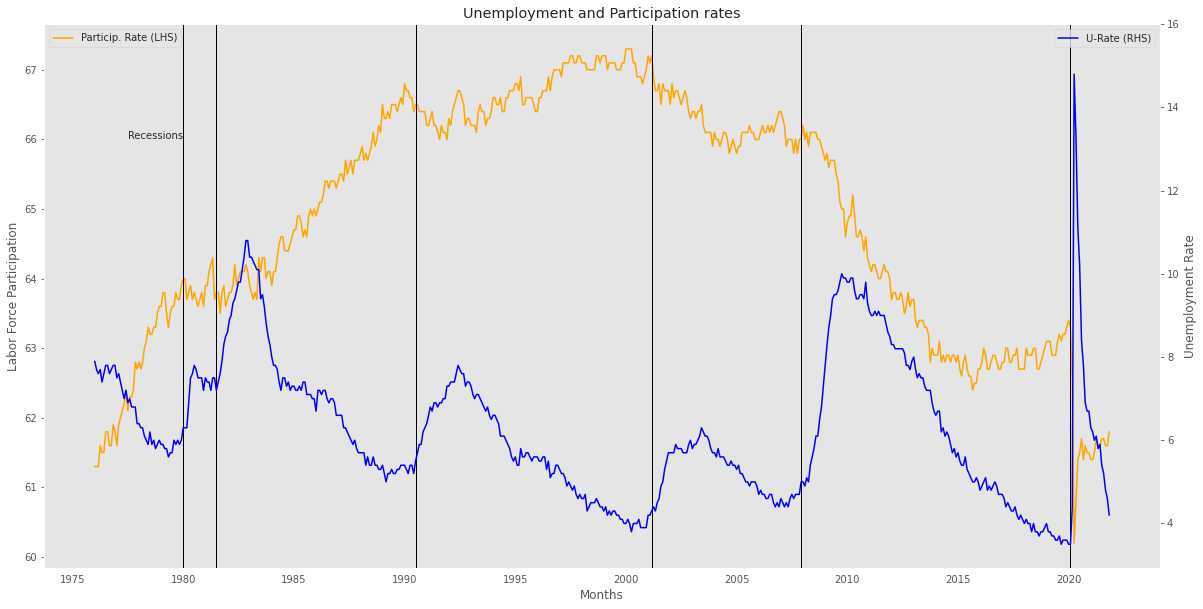

In [35]:
#Series selection
y = df_nat_ur_lfp["unemployment_rate"]
x = df_nat_ur_lfp["labor_force_participation"]

#Axis 1
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_xlabel('Months')
ax1.set_ylabel('Labor Force Participation')
ax1.plot(x, color="orange", label="Particip. Rate (LHS)")

#Axis 2
ax2 = ax1.twinx()
ax2.set_ylabel('Unemployment Rate') 
ax2.tick_params(axis='y')
ax2.plot(y, color="b", label="U-Rate (RHS)")

# Add legend in proper locations
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

#Remove grids
ax1.grid(False)
ax2.grid(False)

plt.gca()

#Add vertical line for recessions (1980)
x1_line_annotation = dt.datetime(1980, 1, 1)
x1_text_annotation = x1_line_annotation
ax1.axvline(x=x1_line_annotation, color='black', linewidth=1)
ax1.annotate("Recessions", xy=[x1_text_annotation, 66], horizontalalignment='right')

#Add vertical line for recessions (1981)
x1_line_annotation = dt.datetime(1981, 7, 1)
x1_text_annotation = x1_line_annotation
ax1.axvline(x=x1_line_annotation, color='black', linewidth=1)

#Add vertical line for recessions (1990)
x1_line_annotation = dt.datetime(1990, 7, 1)
x1_text_annotation = x1_line_annotation
ax1.axvline(x=x1_line_annotation, color='black', linewidth=1)

#Add vertical line for recessions (2001)
x1_line_annotation = dt.datetime(2001, 3, 1)
x1_text_annotation = x1_line_annotation
ax1.axvline(x=x1_line_annotation, color='black', linewidth=1)

#Add vertical line for recessions (2007-08)
x1_line_annotation = dt.datetime(2007, 12, 1)
x1_text_annotation = x1_line_annotation
ax1.axvline(x=x1_line_annotation, color='black', linewidth=1)

#Add vertical line for recessions (2020)
x1_line_annotation = dt.datetime(2020, 2, 1)
x1_text_annotation = x1_line_annotation
ax1.axvline(x=x1_line_annotation, color='black', linewidth=1)

#Resizing
plt.yticks([4, 6, 8, 10, 12, 14, 16]) 
plt.rcParams['figure.figsize'] = [10, 5]

#Title
plt.title('Unemployment and Participation rates')

Another method for distinguish how severe COVID's impact was on U.S unemployment rate and labor force participation is to compare relative to previous economic recessions. 

Taking into consideration all recessions from 1979 to 2021, we can visually interpret how quickly the COVID pandemic triggered negative shocks to the labor market in relation to past economic downturns.

In all of them, the unemployment rate expectedly rises, but in the case of the COVID-19 recession, the scale is off the charts.

In recent recessions, however, it seems that the fall in labor force participation was accelerated.

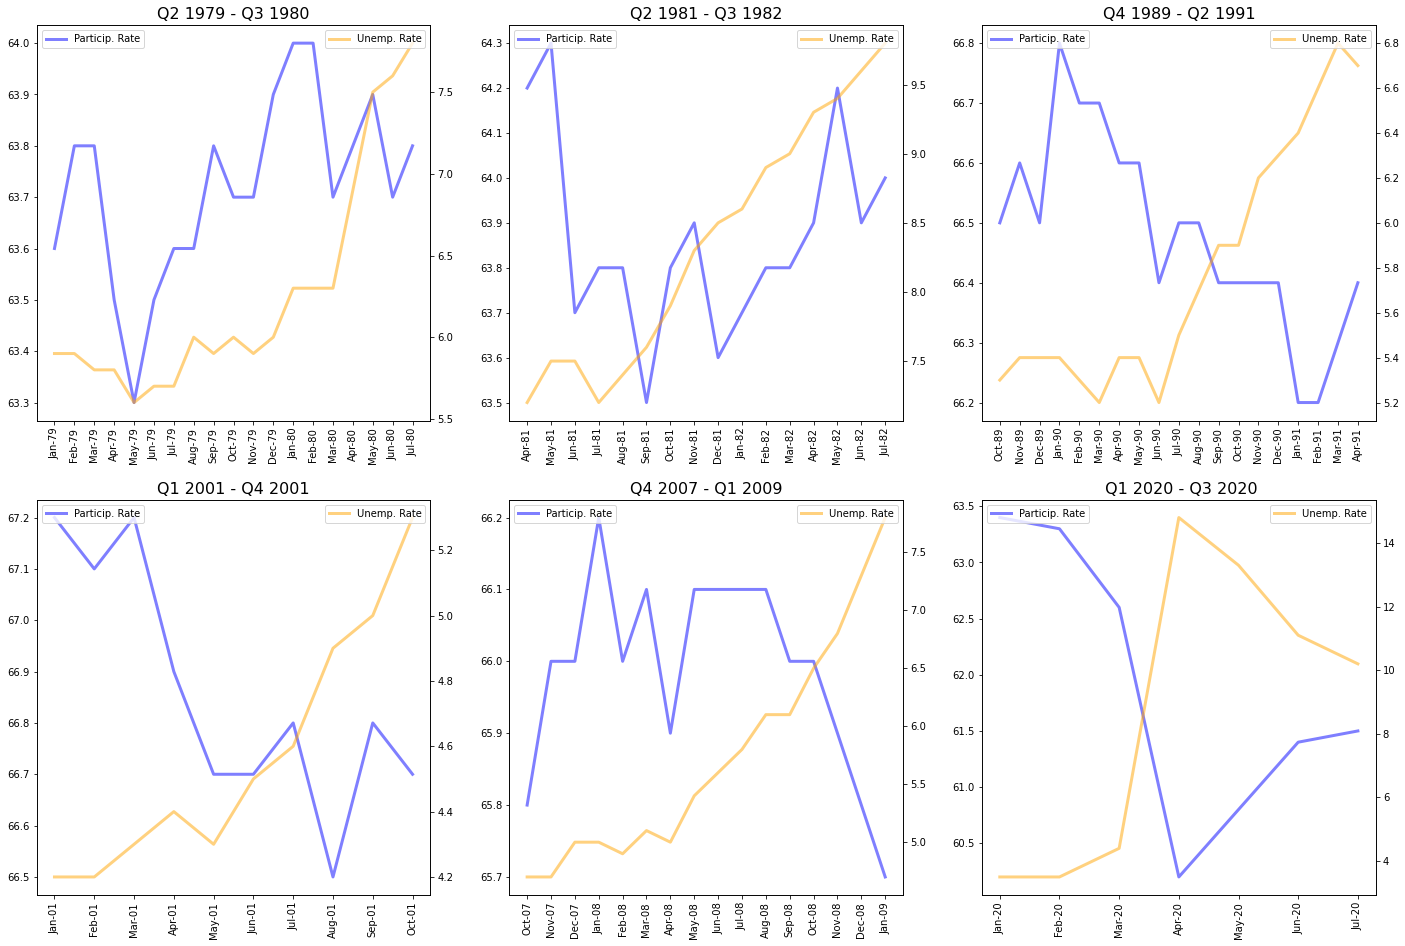

In [18]:
# Build subsets for each recession
# Q2 1979 - Q3 1980
recession_79 = df_nat_ur_lfp.query("date >= '1979-01-01'"
    ).query("date <= '1980-07-01'")

# Q2 1981 - Q3 1982
recession_81 = df_nat_ur_lfp.query("date >= '1981-04-01'"
    ).query("date <= '1982-07-01'")

# Q4 1989 - Q2 1991
recession_89 = df_nat_ur_lfp.query("date >= '1989-10-01'"
    ).query("date <= '1991-04-01'")

# Q1 2001 - Q4 2001 
recession_01 = df_nat_ur_lfp.query("date >= '2001-01-01'"
    ).query("date <= '2001-10-01'")

# Q4 2007 - Q1 2009
recession_07 = df_nat_ur_lfp.query("date >= '2007-10-01'"
    ).query("date <= '2009-01-01'")

# Q1 2020 - Q3 2020
recession_covid = df_nat_ur_lfp.query("date >= '2020-01-01'"
    ).query("date <= '2020-07-01'")

# Correct dates

# Q2 1979 - Q3 1980
recession_79 = recession_79.reset_index()
recession_79["date"] = recession_79["date"].dt.strftime('%b-%y')
recession_79 = recession_79.set_index('date')

# Q2 1981 - Q3 1982
recession_81 = recession_81.reset_index()
recession_81["date"] = recession_81["date"].dt.strftime('%b-%y')
recession_81 = recession_81.set_index('date')

# Q4 1989 - Q2 1991
recession_89 = recession_89.reset_index()
recession_89["date"] = recession_89["date"].dt.strftime('%b-%y')
recession_89 = recession_89.set_index("date")

# Q1 2001 - Q4 2001
recession_01 = recession_01.reset_index()
recession_01["date"] = recession_01["date"].dt.strftime('%b-%y')
recession_01 = recession_01.set_index('date')

# Q4 2007 - Q1 2009
recession_07 = recession_07.reset_index()
recession_07["date"] = recession_07["date"].dt.strftime('%b-%y')
recession_07 = recession_07.set_index('date')

# Q1 2020 - Q3 2020
recession_covid = recession_covid.reset_index()
recession_covid["date"] = recession_covid["date"].dt.strftime('%b-%y')
recession_covid = recession_covid.set_index('date')

# Plot UR and LFP for each reported recession
fig, ax = plt.subplots(2, 3, figsize=(24,16))

charts = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

# labor force participation for each recession
lfp_rec = [
    recession_79["labor_force_participation"],
    recession_81["labor_force_participation"], 
    recession_89["labor_force_participation"],
    recession_01["labor_force_participation"],
    recession_07["labor_force_participation"],
    recession_covid["labor_force_participation"]]

# unemployment rate for each recession
ur_rec = [
    recession_79["unemployment_rate"],
    recession_81["unemployment_rate"], 
    recession_89["unemployment_rate"],
    recession_01["unemployment_rate"],
    recession_07["unemployment_rate"],
    recession_covid["unemployment_rate"]]

for (i, j) in zip(charts, lfp_rec):
    ax[i].plot(j, color = 'b', alpha=0.5, linewidth=3)
    ax[i].tick_params(axis='y')
    ax[i].legend(["Particip. Rate"], loc='upper left')
    [t.set_rotation(90) for t in ax[i].get_xticklabels()]
    
for i in charts:
    ax[i] = ax[i].twinx()
    
for (i, k) in zip(charts, ur_rec):
    ax[i].plot(k, color = 'orange', alpha=0.5, linewidth=3)
    ax[i].tick_params(axis='y')
    ax[i].legend(["Unemp. Rate"], loc='upper right')
    [t.set_rotation(90) for t in ax[i].get_xticklabels()]
    
rec_titles = ["Q2 1979 - Q3 1980", "Q2 1981 - Q3 1982", "Q4 1989 - Q2 1991", 
            "Q1 2001 - Q4 2001", "Q4 2007 - Q1 2009", " Q1 2020 - Q3 2020"]

for (i, j) in zip(charts, rec_titles):
    ax[i].set_title(j, fontsize=16)

#Remove grids
sns.set_style("dark")

## 5. A closer investigation of labor force participation in recent years: state-level analysis

To try to understand the unusual pattern of the labor force participation, we investigate the state-level data and see whether there are significant divergences before, during and after the worst moments of the COVID-19 crisis. 

Then, we look into the potential sources of differentiation, if any. We check whether there is a significant divergence by region. Then, we create a map to visually understand the potential outliers and level-changes. 

### 5.1 Comparing aggregate state-level data with different recessions

We start with a similar analysis as we did at the national level. A state-level average might help to reduce the effect of heavyweight states (e.g. California and New York) on the national weighted average.

However, the conclusions are broadly similar than the one we had with the national-level information.

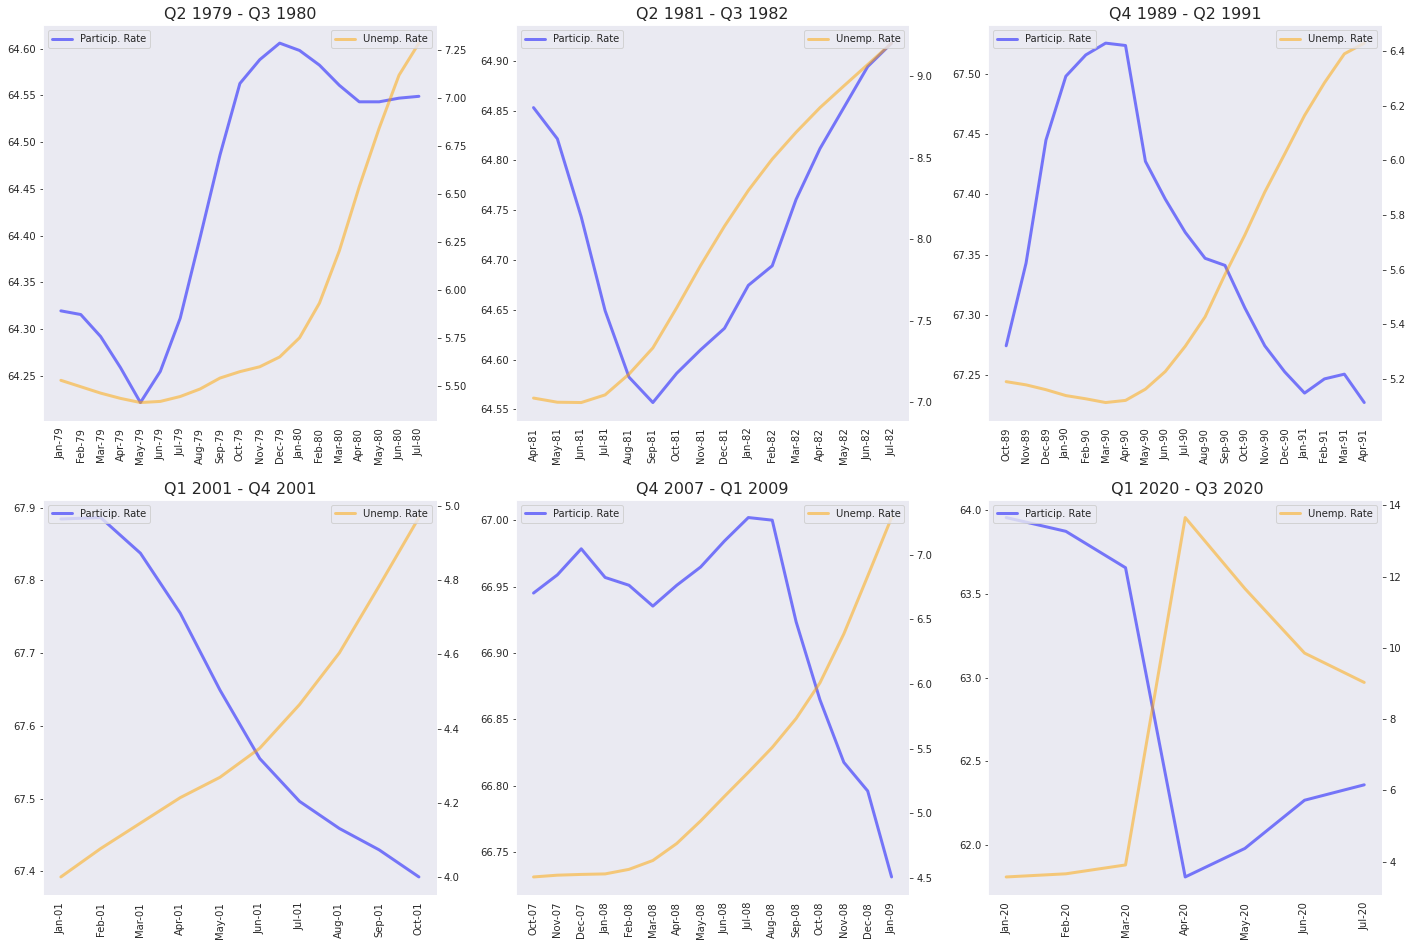

In [19]:
# Build subsets for each recession
# Q2 1979 - Q3 1980
recession_79 = df_ur_lfp.query("date >= '1979-01-01'"
    ).query("date <= '1980-07-01'")

# Q2 1981 - Q3 1982
recession_81 = df_ur_lfp.query("date >= '1981-04-01'"
    ).query("date <= '1982-07-01'")

# Q4 1989 - Q2 1991
recession_89 = df_ur_lfp.query("date >= '1989-10-01'"
    ).query("date <= '1991-04-01'")

# Q1 2001 - Q4 2001 
recession_01 = df_ur_lfp.query("date >= '2001-01-01'"
    ).query("date <= '2001-10-01'")

# Q4 2007 - Q1 2009
recession_07 = df_ur_lfp.query("date >= '2007-10-01'"
    ).query("date <= '2009-01-01'")

# Q1 2020 - Q3 2020
recession_covid = df_ur_lfp.query("date >= '2020-01-01'"
    ).query("date <= '2020-07-01'")


# Q2 1979 - Q3 1980
recession_79 = recession_79.reset_index()
recession_79["date"] = recession_79["date"].dt.strftime('%b-%y')
recession_79 = recession_79.set_index('date')

# Q2 1981 - Q3 1982
recession_81 = recession_81.reset_index()
recession_81["date"] = recession_81["date"].dt.strftime('%b-%y')
recession_81 = recession_81.set_index('date')

# Q4 1989 - Q2 1991
recession_89 = recession_89.reset_index()
recession_89["date"] = recession_89["date"].dt.strftime('%b-%y')
recession_89 = recession_89.set_index("date")

# Q1 2001 - Q4 2001
recession_01 = recession_01.reset_index()
recession_01["date"] = recession_01["date"].dt.strftime('%b-%y')
recession_01 = recession_01.set_index('date')

# Q4 2007 - Q1 2009
recession_07 = recession_07.reset_index()
recession_07["date"] = recession_07["date"].dt.strftime('%b-%y')
recession_07 = recession_07.set_index('date')

# Q1 2020 - Q3 2020
recession_covid = recession_covid.reset_index()
recession_covid["date"] = recession_covid["date"].dt.strftime('%b-%y')
recession_covid = recession_covid.set_index('date')

# Plot UR and LFP for each reported recession
fig, ax = plt.subplots(2, 3, figsize=(24,16))

charts = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

# mean labor force participation for each recession
lfp_rec = [
    recession_79["labor_force_participation"].mean(axis=1),
    recession_81["labor_force_participation"].mean(axis=1), 
    recession_89["labor_force_participation"].mean(axis=1),
    recession_01["labor_force_participation"].mean(axis=1),
    recession_07["labor_force_participation"].mean(axis=1),
    recession_covid["labor_force_participation"].mean(axis=1)]

# mean unemployment rate for each recession
ur_rec = [
    recession_79["unemployment_rate"].mean(axis=1),
    recession_81["unemployment_rate"].mean(axis=1), 
    recession_89["unemployment_rate"].mean(axis=1),
    recession_01["unemployment_rate"].mean(axis=1),
    recession_07["unemployment_rate"].mean(axis=1),
    recession_covid["unemployment_rate"].mean(axis=1)]


for (i, j) in zip(charts, lfp_rec):
    ax[i].plot(j, color = 'b', alpha=0.5, linewidth=3)
    ax[i].tick_params(axis='y')
    ax[i].legend(["Particip. Rate"], loc='upper left')
    [t.set_rotation(90) for t in ax[i].get_xticklabels()]
    
for i in charts:
    ax[i] = ax[i].twinx()
    
for (i, k) in zip(charts, ur_rec):
    ax[i].plot(k, color = 'orange', alpha=0.5, linewidth=3)
    ax[i].tick_params(axis='y')
    ax[i].legend(["Unemp. Rate"], loc='upper right')
    [t.set_rotation(90) for t in ax[i].get_xticklabels()]
    
rec_titles = ["Q2 1979 - Q3 1980", "Q2 1981 - Q3 1982", "Q4 1989 - Q2 1991", 
            "Q1 2001 - Q4 2001", "Q4 2007 - Q1 2009", " Q1 2020 - Q3 2020"]

for (i, j) in zip(charts, rec_titles):
    ax[i].set_title(j, fontsize=16)

#Remove grids
sns.set_style("dark")

### 5.2 Analysis of Pre, Intra, and Post COVID-19 state-level labor markets

In order to compare how State's labor force participation has changed over time, we will need to construct three dataframes for three separate periods of time. The first subset of data will be for the time period of 2015 - 2019 (denoted as pre-COVID). This pre-COVID period with relative economic stability will allow for a clear contrast in interpreting the impact COVID had on state-level unemployment rates and labor force participation. The next period will be January 1, 2020 - January 31, 2020 (denoted as intra-COVID), and the third period will be January 1st, 2021 to present (denoted as post-COVID).

The plots below will display annual, state-level mean values for labor force participation and unemployment rate. Moving from left to right, we can observe the state's transitions over time, where as expected, the Intra-COVID period witnessed a 3.04% mean increase in unemployment rate and 0.93% mean decrease in labor force participation. 

More interestingly, the movement from intra-COVID to post-COVID reveals that unemployment rate fell by 2.22% and labor force participation decreased by 0.32%. While a marginal portion of the decrease in unemployment can be explained by those leaving the labor force, the phenomenon to focus on is the notion that individuals during this period continued to leave the labor force amidst improving COVID conditions. Additionally, you can see that in in the pre-COVID era, states were in a relatively tight cluster, however, as time progressed we notice that the dispersion of the points increases, where now it is more common for states to have varying levels of unemployment and labor force participation.

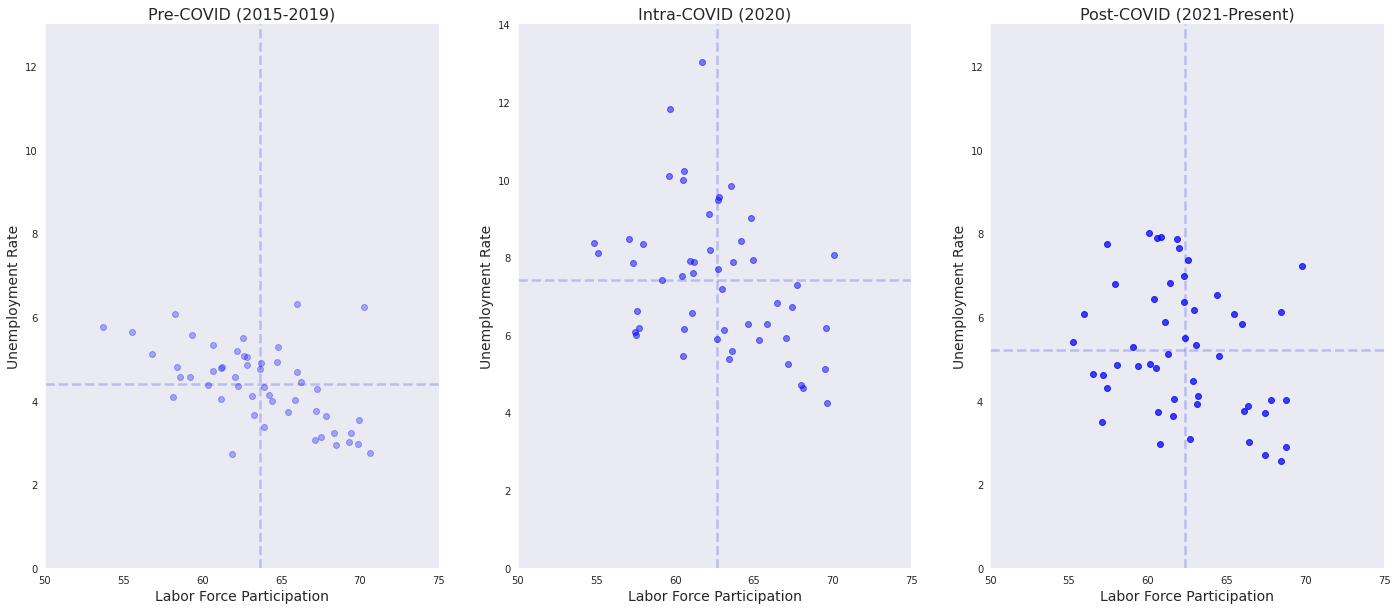

In [20]:
# Generate three datasets for three periods of interest (pre, intra, and post COVID)
df_pre_covid = df_ur_lfp["2015-01-01":"2019-01-01"]

df_intra_covid = df_ur_lfp["2020-01-01":"2020-12-31"]

df_post_covid = df_ur_lfp["2021-01-01":"2021-10-31"]


fig, ax = plt.subplots(1, 3, figsize=(24, 10))

ax[0].scatter(
    df_pre_covid["labor_force_participation"].mean(), 
    df_pre_covid["unemployment_rate"].mean(), color='b', alpha=0.3)
ax[0].set_title("Pre-COVID (2015-2019)", fontsize=16)
ax[0].set_xlim(50, 75)
ax[0].set_ylim(0, 13)
ax[0].axvline(
    np.mean(df_pre_covid["labor_force_participation"].mean()), 
    color='b', ls='--', 
    lw=2.5, 
    alpha=0.2)
ax[0].axhline(
    np.mean(df_pre_covid["unemployment_rate"].mean()), 
    color='b', ls='--', 
    lw=2.5, 
    alpha = 0.2)

ax[1].scatter(
    df_intra_covid["labor_force_participation"].mean(), 
    df_intra_covid["unemployment_rate"].mean(), color='b', alpha=0.5)
ax[1].set_title("Intra-COVID (2020)", fontsize=16)
ax[1].set_xlim(50, 75)
ax[1].set_ylim(0, 14)
ax[1].axvline(
    np.mean(df_intra_covid["labor_force_participation"].mean()), 
    color='b', ls='--', 
    lw=2.5, 
    alpha=0.2)
ax[1].axhline(
    np.mean(df_intra_covid["unemployment_rate"].mean()), 
    color='b', ls='--', 
    lw=2.5, 
    alpha = 0.2)

ax[2].scatter(
    df_post_covid["labor_force_participation"].mean(), 
    df_post_covid["unemployment_rate"].mean(), color='b', alpha=0.75)
ax[2].set_title("Post-COVID (2021-Present)", fontsize=16)
ax[2].set_xlim(50, 75)
ax[2].set_ylim(0, 13)
ax[2].axvline(
    np.mean(df_post_covid["labor_force_participation"].mean()), 
    color='b', ls='--', 
    lw=2.5, 
    alpha=0.2)
ax[2].axhline(
    np.mean(df_post_covid["unemployment_rate"].mean()), 
    color='b', ls='--', 
    lw=2.5, 
    alpha = 0.2)

for i in [0, 1, 2]:
    ax[i].set_ylabel("Unemployment Rate", fontsize=14)
    ax[i].set_xlabel("Labor Force Participation", fontsize=14)

for i in [0, 1, 2]:
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)

#Remove grids
sns.set_style("dark")

As the charts show, the unemployment rate increased during the worst moments of the COVID-19 crisis, and now is falling though remains above pre-COVID level.

The participation, however, decreased and remains relatively depressed.

In [21]:
ur_titles = ["pre-COVID UR:", "intra-COVID UR:", "post-COVID UR:"]
ur_sets = [df_pre_covid, df_intra_covid, df_post_covid]

for (i, j) in zip(ur_titles, ur_sets):
    print(i, round(np.mean(j["unemployment_rate"].mean()), 2),"%")

lfp_titles = ["pre-COVID LFP:", "intra-COVID LFP:", "post-COVID LFP:"]
lfp_sets = [df_pre_covid, df_intra_covid, df_post_covid]

for (i, j) in zip(lfp_titles, lfp_sets):
    print(i, round(np.mean(j["labor_force_participation"].mean()), 2),"%")

pre-COVID UR: 4.39 %
intra-COVID UR: 7.41 %
post-COVID UR: 5.22 %
pre-COVID LFP: 63.62 %
intra-COVID LFP: 62.66 %
post-COVID LFP: 62.34 %


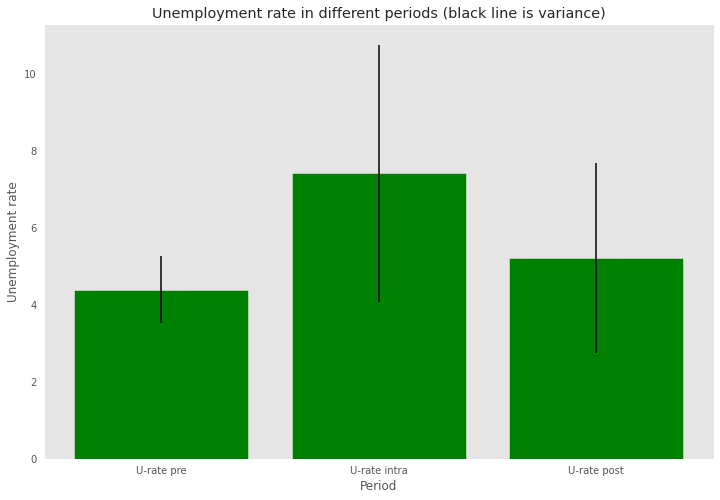

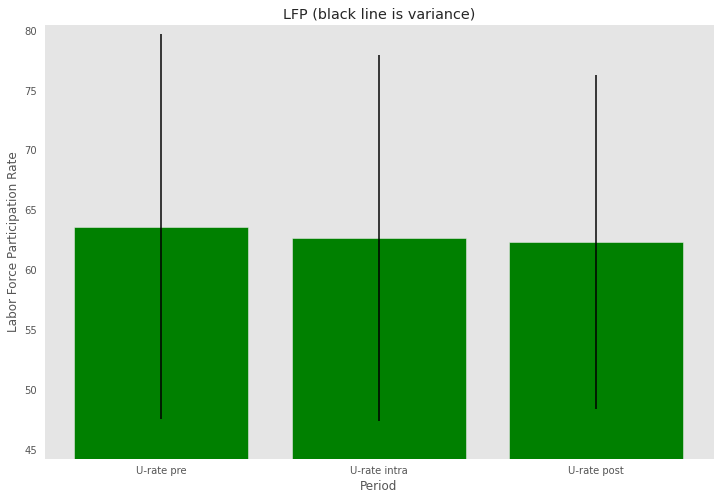

In [34]:
# Visual representation of those averages

# Organizing variables
avg_pre_ur = df_pre_covid["unemployment_rate"].mean().mean()
avg_intra_ur = df_intra_covid["unemployment_rate"].mean().mean()
avg_post_ur = df_post_covid["unemployment_rate"].mean().mean()

var_pre_ur = df_pre_covid["unemployment_rate"].mean().var()
var_intra_ur = df_intra_covid["unemployment_rate"].mean().var()
var_post_ur = df_post_covid["unemployment_rate"].mean().var()

# Chart style
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12,8))

# Add variables to a chart
x = ['U-rate pre', 'U-rate intra', 'U-rate post']
average_ur = [avg_pre_ur, avg_intra_ur, avg_post_ur]
variance_ur = [var_pre_ur, var_intra_ur, var_post_ur]

# Organizing chart and plotting
x_pos = [i for i, _ in enumerate(x)]
plt.bar(x_pos, average_ur, color='green', yerr=variance_ur)

# Labeling, title and ticks
plt.xlabel("Period")
plt.ylabel("Unemployment rate")
plt.title("Unemployment rate in different periods (black line is variance)")
plt.xticks(x_pos, x)

#Remove grids
plt.grid(b=None)

# Plot chart
plt.show()

# Organizing variables
avg_pre_lfp = df_pre_covid["labor_force_participation"].mean().mean()
avg_intra_lfp = df_intra_covid["labor_force_participation"].mean().mean()
avg_post_lfp = df_post_covid["labor_force_participation"].mean().mean()

var_pre_lfp = df_pre_covid["labor_force_participation"].mean().var()
var_intra_lfp = df_intra_covid["labor_force_participation"].mean().var()
var_post_lfp = df_post_covid["labor_force_participation"].mean().var()

# Chart style
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12,8))

# Add variables to a chart
x2 = ['U-rate pre', 'U-rate intra', 'U-rate post']
average_lfp = [avg_pre_lfp, avg_intra_lfp, avg_post_lfp]
variance_lfp = [var_pre_lfp, var_intra_lfp, var_post_lfp]

# Organizing chart and plotting
x_pos2 = [i for i, _ in enumerate(x)]
plt.bar(x_pos, average_lfp, color='green', yerr=variance_lfp)

# Labeling, title and ticks
plt.xlabel("Period")
plt.ylabel("Labor Force Participation Rate")
plt.title("LFP (black line is variance)")
plt.xticks(x_pos2, x2)

# Restrict Axis to make it easier to see
low = float(min(average_lfp) - max(variance_lfp))
high = float(max(average_lfp) + min(variance_lfp))
plt.ylim([low-2, high+3])

#Remove grids
plt.grid(b=None)
# Plot chart
plt.show()

### 5.3 Regional analysis: North, South, West and Mid-West

Now we check if there are any obvious regional differences in unemployment rate and labor force participation over the three periods.

The darkest dots represent the most recent period (post-COVID), where we can see that over time states labor force participation has generally shifted leftward, demonstrating that all geographic regions of the U.S faced decreases in labor supply. 

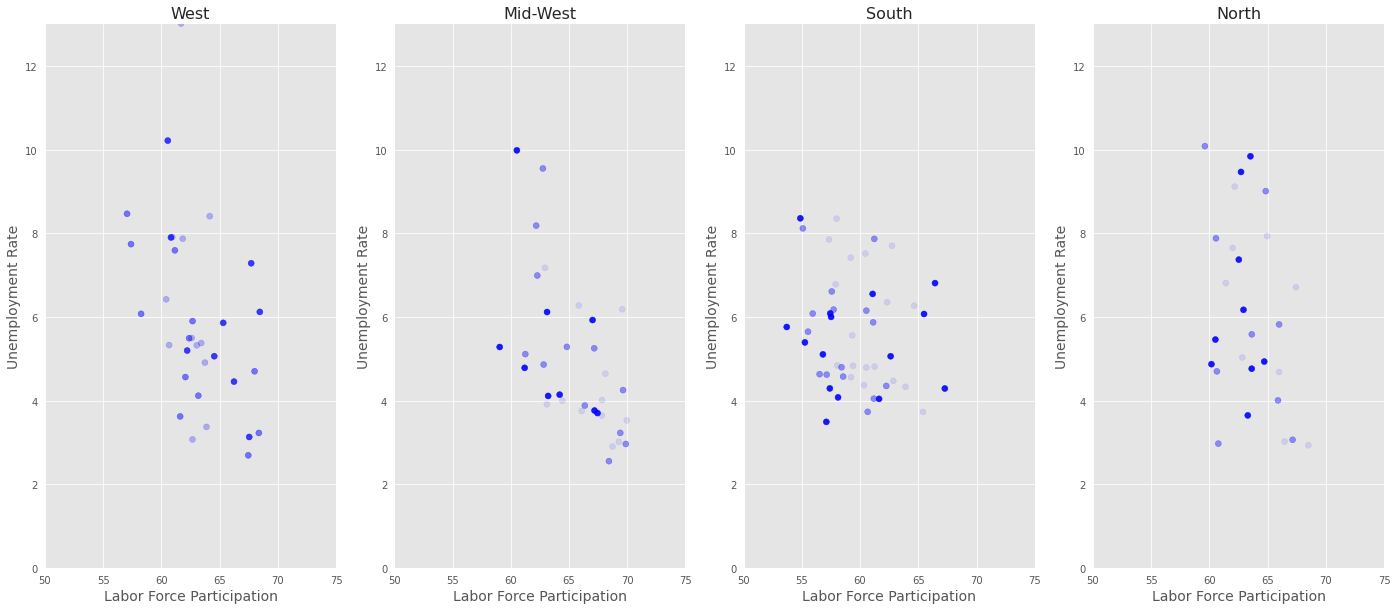

In [23]:
# Pre, intra, and post COVID unemployment rate and labor force participation for Western U.S
west = ["WA", "OR", "CA", "ID", "MT", "WY", 
         "NV", "UT", "CO", "AZ", "NM"]

pre_west_ur = df_pre_covid["unemployment_rate"][west]
pre_west_lfp = df_pre_covid["labor_force_participation"][west]
intra_west_ur = df_intra_covid["unemployment_rate"][west]
intra_west_lfp = df_intra_covid["labor_force_participation"][west]
post_west_ur = df_post_covid["unemployment_rate"][west]
post_west_lfp = df_post_covid["labor_force_participation"][west]

# Pre, intra, and post COVID unemployment rate and labor force participation for Mid-Western U.S
mid_west = ["SD", "NE", "KS", "MN", "IA", 
            "MO", "WI", "IL", "MI", "IN", "OH"]

pre_mid_ur = df_pre_covid["unemployment_rate"][mid_west]
pre_mid_lfp = df_pre_covid["labor_force_participation"][mid_west]
intra_mid_ur = df_intra_covid["unemployment_rate"][mid_west]
intra_mid_lfp = df_intra_covid["labor_force_participation"][mid_west]
post_mid_ur = df_post_covid["unemployment_rate"][mid_west]
post_mid_lfp = df_post_covid["labor_force_participation"][mid_west]

# Pre, intra, and post COVID unemployment rate and labor force participation for Northern U.S
north = ["PA", "NY", "NJ", "CT", 
        "MA", "RI", "NH", "VT", "ME"]

pre_north_ur = df_pre_covid["unemployment_rate"][north]
pre_north_lfp = df_pre_covid["labor_force_participation"][north]
intra_north_ur = df_intra_covid["unemployment_rate"][north]
intra_north_lfp = df_intra_covid["labor_force_participation"][north]
post_north_ur = df_post_covid["unemployment_rate"][north]
post_north_lfp = df_post_covid["labor_force_participation"][north]

# Pre, intra, and post COVID unemployment rate and labor force participation for Southern U.S
south = ["TX", "OK", "AR", "LA", "MS", "AL", "TN", "KY", 
        "WV", "VA", "DE", "MD", "NC", "SC", "GA", "FL"]

pre_south_ur = df_pre_covid["unemployment_rate"][south]
pre_south_lfp = df_pre_covid["labor_force_participation"][south]
intra_south_ur = df_intra_covid["unemployment_rate"][south]
intra_south_lfp = df_intra_covid["labor_force_participation"][south]
post_south_ur = df_post_covid["unemployment_rate"][south]
post_south_lfp = df_post_covid["labor_force_participation"][south]

# Scatter plots showing transitions through pre, intra, and post COVID by region 
fig, ax = plt.subplots(1,4, figsize=(24,10))

west_ur = [pre_west_ur, intra_west_ur, post_west_ur]
west_lfp = [pre_west_lfp, intra_west_lfp, post_west_lfp]

for (j, i) in zip(west_ur, west_lfp):
    ax[0].scatter(
        i.mean(),
        j.mean(),
        color='b',
        alpha=[0.25, 0.5, 0.75])

mid_ur = [pre_mid_ur, intra_mid_ur, post_mid_ur]
mid_lfp = [pre_mid_lfp, intra_mid_lfp, post_mid_lfp]

for (j, i) in zip(mid_ur, mid_lfp):
    ax[1].scatter(
        i.mean(),
        j.mean(),
        color='b',
        alpha=[0.1, 0.4, 0.9]
    )

south_ur = [pre_south_ur, intra_south_ur, post_south_ur]
south_lfp = [pre_south_lfp, intra_south_lfp, post_south_lfp]

for (j, i) in zip(south_ur, south_lfp):
    ax[2].scatter(
        i.mean(),
        j.mean(),
        color='b',
        alpha=[0.1, 0.4, 0.9]
    )

north_ur = [pre_north_ur, intra_north_ur, post_north_ur]
north_lfp = [pre_north_lfp, intra_north_lfp, post_north_lfp]

for (j, i) in zip(north_ur, north_lfp):
    ax[3].scatter(
        i.mean(),
        j.mean(),
        color='b',
        alpha=[0.1, 0.4, 0.9]
    )

for i in [0, 1, 2, 3]:
    ax[i].set_xlim(50, 75),
    ax[i].set_ylim(0, 13)

region_titles = ["West", "Mid-West", "South", "North"]
count = [0, 1, 2, 3]

for (i, j) in zip(count, region_titles):
    ax[i].set_title(j, fontsize=16)

for i in [0, 1, 2, 3]:
    ax[i].set_ylabel("Unemployment Rate", fontsize=14)
    ax[i].set_xlabel("Labor Force Participation", fontsize=14)

for i in [0, 1, 2, 3]:
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)


#Remove grids
sns.set_style("dark")

Taking it a step further, the map above shows the monthly changes in state's labor force participation from January 2015 - July 2021. Moving from 2015 - present, the graphic illustrates that all geographic regions of the U.S suffered from decreases in labor force participation, where the mid-west faired the best in terms of maintaining their labor supply.

With the exception of the recessions of 1979 and 1981, it is clear that these contractual economic conditions amplify inverse shifts between unemployment rate and labor force participation, where at the time of a recession, labor force participation decreases, resulting in an increase in unemployment rate. With respect to the COVID pandemic (last pane), we can interpret that the magnitude of its impact on LFP and UR was larger than any other previous recession.

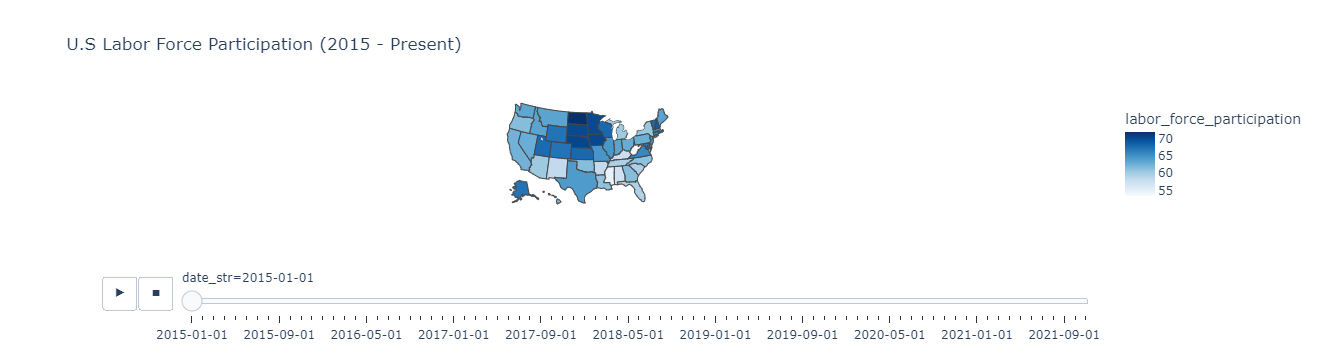

In [24]:
df_long = df_ur_lfp.stack().reset_index()

fig = px.choropleth(
    df_long.query("date >= '2015-01-01'").assign(date_str=lambda x: x["date"].astype(str)),
    locations="area", 
    locationmode="USA-states", 
    color="labor_force_participation",
    color_continuous_scale="blues",
    scope="usa",
    animation_frame="date_str",
    title="U.S Labor Force Participation (2015 - Present)"
)
fig.show()

## 7. Potential Impacts of Pandemic Unemployment Assistance on Labor Force Participation

### 7.1. Earlier and later announcements of the end of the PUA

Returning now back to the question of "did the date when states announced the end of PUA impact LFP conditions?" we will look to illustrate whether it is the case that announcing the expiration of PUA resulted in an immediate increase in LFP. 

For the purposes of this exercise, we will bucket states into two groups, either "early" or "late." 

In order to build a nearly balanced sample, we selected the cut-off date for the "early" group to be before 2021-05-15, and any state that made their announcement afterwards qualifies as "late". The sample of data is composed of 24 states, thus why you will notice that not all are states are included.

Of the states that had data available for collection, the most frequently occurring dates when "early" and "late" states announced the end of PUA was 05/11/21 and 05/17/21, respectively. The most frequently occurring expiration date for both groups was 6/26/21. Between these points in time, it is worth noting that mean LFP for both the "early" and "late" groups was increasing. Intuitively, this reaction aligns with the permanent income hypothesis. For example, it is assumed that residents who left the labor force were using PUA as replacement income, and when PUA expiration was announced, this anticipated shock to income in time t-1 caused individuals to act in the interest of consumption smoothing, thus they were inclined to return to the labor market. 

In terms of distinguishing whether an early or late announcement date had an impact on LFP rate, we can see from the plot that "late" states had a more rapid increase in LFP between the window of announcement and expiration, however, they also had an initially lower level of LFP relative to "early" states. Additionally, since the window of time between late announcement and expiration is shorter than that of states with an early announcement, residents in "late" states had less time to interpret the income shock, possibly causing a sharper increase in LFP, demonstrated by the kink in the "Late announcement state" line in early June.

In [25]:
# Break the states into two groups, early announcement and late announcement
# Early announcement qualifies as announcements proir to 2021-05-15
early_annc = ui_dates.query("annc_date <= '2021-05-15'")
early_states = ['AK','AL','AR','AZ','GA','IA','ID','MO',
                'MS','MT','ND','SC','SD','TN','UT','WY']

# Late announcement qualifies as announcements after to 2021-05-15
late_annc = ui_dates.query("annc_date >= '2021-05-15'")
late_states = ['FL', 'IN', 'LA', 'MD', 'NE', 'NH', 'OH', 'OK', 'TX', 'WV']

# Incorporate all of 2021 for possible trends
ui = df_ur_lfp["labor_force_participation"].query("date >= '2021-01-01'")

# Mean monthly LFP for all early states
ui_early = ui[['AK','AL','AR','AZ','GA','IA','ID','MO',
               'MS','MT','SC','SD','TN','UT','WY']].mean(axis=1)

# Mean monthly LFP for all late states
ui_late = ui[['FL', 'IN', 'LA', 'MD', 'NE', 'NH', 'OH', 'OK', 'TX', 'WV']].mean(axis=1)

**TODO: We can make more separations by using this link -- https://www.cbsnews.com/news/unemployment-benefits-state-end-saturday-440k/**

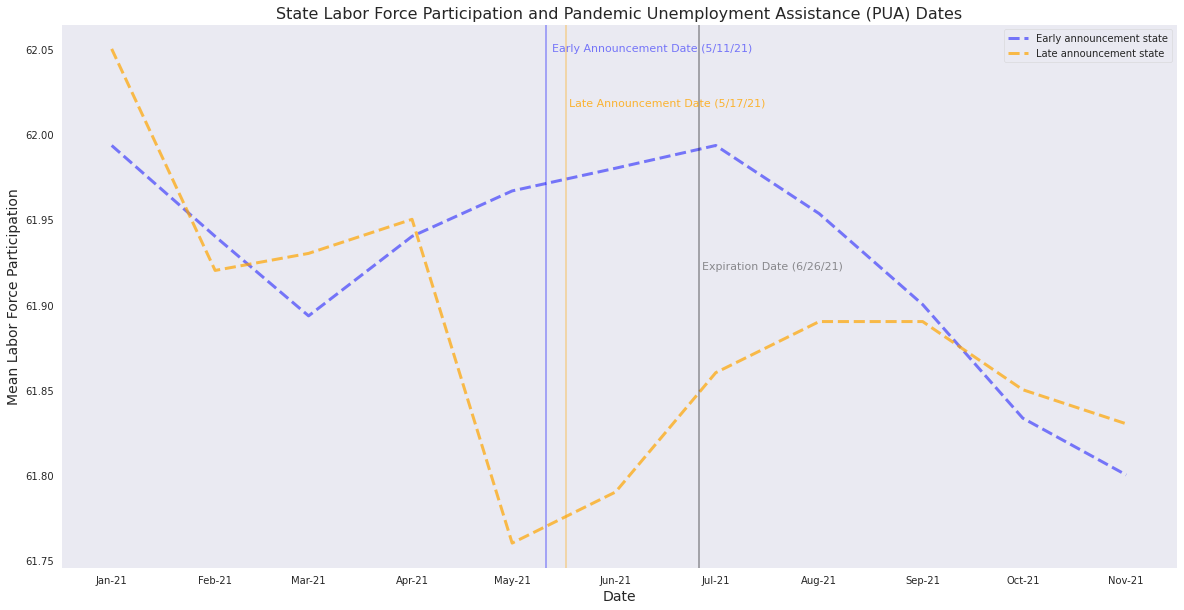

In [28]:
# Create plot showing early and late announcement states LFP
fig, ax = plt.subplots(figsize=(20,10))

ax.plot(ui_early, color = 'b', alpha=0.5, linewidth=3, linestyle='--')
ax.plot(ui_late, color = 'orange', alpha=0.7, linewidth=3, linestyle ='--')
 
# Most frequent announcement dates for "early" and "late" states
plt.axvline(dt.datetime(2021,5,11), color='b', alpha=0.3, linewidth=2)
plt.axvline(dt.datetime(2021,5,17), color='orange', alpha=0.3, linewidth=2)

# Most frequent expiration date of "early" and "late" states
plt.axvline(dt.datetime(2021,6,26), color='black', alpha=0.3, linewidth=2)

trans = ax.get_xaxis_transform()

plt.text(
    dt.datetime(2021,5,13), 0.95, "Early Announcement Date (5/11/21)", 
    transform=trans, alpha=0.5, fontsize=11, color='b')

plt.text(
    dt.datetime(2021,5,18), 0.85, "Late Announcement Date (5/17/21)", 
    transform=trans, alpha=0.8, fontsize=11, color='orange')

plt.text(
    dt.datetime(2021,6,27), 0.55, "Expiration Date (6/26/21)", 
    transform=trans, alpha=0.5, fontsize=11)

plt.legend(["Early announcement state", "Late announcement state"])

plt.title("State Labor Force Participation and Pandemic Unemployment Assistance (PUA) Dates", fontsize=16)
plt.ylabel("Mean Labor Force Participation", fontsize=14)
plt.xlabel("Date", fontsize=14)

#Format dates
myFmt = mdates.DateFormatter('%b-%y')
ax.xaxis.set_major_formatter(myFmt)    

#Remove grids
ax.grid(False)


From the table below, we can reaffirm the findings that "late" states had a greater percentage increase in LFP within the announcement and expiration window. Referring back to the hypothesis related to "late" states abbreviated timeline, these results suggest that it may be advantageous for states to announce the expiration of unemployment benefits nearer to the actual expiration date in order to create a greater increase in LFP, however, this approach seems questionable ethically.  

In [27]:
# Create table for percentage change in mean LFP for "early" states
early = pd.DataFrame(ui_early)
name_early = {0 : "mean_LFP_early"}
early = early.rename(columns=name_early)
early["growth_rate_early"] = ((early["mean_LFP_early"] - early["mean_LFP_early"].shift()) / early["mean_LFP_early"].shift()) 

# Create table for percentage change in mean LFP for "late" states
late = pd.DataFrame(ui_late)
name_late = {0 : "mean_LFP_late"}
late = late.rename(columns=name_late)
late["growth_rate_late"] = ((late["mean_LFP_late"] - late["mean_LFP_late"].shift()) / late["mean_LFP_late"].shift())

# Merge to have one table
early.merge(late, on="date", how="left")

mean_LFP_early  growth_rate_early  mean_LFP_late  growth_rate_late
date                                                                          
2021-01-01       61.993333                NaN          62.05               NaN
2021-02-01       61.940000          -0.000860          61.92         -0.002095
2021-03-01       61.893333          -0.000753          61.93          0.000161
2021-04-01       61.940000           0.000754          61.95          0.000323
2021-05-01       61.966667           0.000431          61.76         -0.003067
2021-06-01       61.980000           0.000215          61.79          0.000486
2021-07-01       61.993333           0.000215          61.86          0.001133
2021-08-01       61.953333          -0.000645          61.89          0.000485
2021-09-01       61.900000          -0.000861          61.89          0.000000
2021-10-01       61.833333          -0.001077          61.85         -0.000646
2021-11-01       61.800000          -0.000539          61.83         -0.000323

### 7.2. "Similar" states and the potential impacts of PUA

Now, we try to identify "similar" states, meaning those that had high correlation of their participation rates and unemployment rates historically, but before the COVID-19. 

After that step is done, we check whether there was a difference of behavior between them. 

By the end, we identify the extent of the PUA that was used by each of those states to see if there is any differentiation.

In [196]:
# See absolute pairwise correlation
def get_top_abs_correlations(df):
    """
    Find the absolute correlation between variables 
    
    Parameters
    ----------
    df : DataFrame
        observations of data from US dates (in our case, we use for unemployment and labor force participation)
    
    Returns
    -------
    correlation : Pandas Series
        List of pairwise correlation from highest to lowest
    """    
    # Get correlation
    correlation = df.corr(method ='pearson')
    
    # Adjust to make a sequence from the highest to the lowest, excluding same-state correlation (which is equal to 1)
    correlation = correlation.mask(np.tril(np.ones(correlation.shape)).astype(np.bool))
    correlation = correlation.unstack()
    correlation = correlation.sort_values(ascending=False)
    
    # Return
    return correlation

# Restrict sample to before COVID
ur_restrict = df_ur_lfp["unemployment_rate"].query("date <= '2019-12-01'")
lfp_restrict = df_ur_lfp["labor_force_participation"].query("date <= '2019-12-01'")

# Create two data series
ur_correlation = get_top_abs_correlations(ur_restrict)
lfp_correlation = get_top_abs_correlations(lfp_restrict)

# Put them together again
concat_correl = pd.concat([ur_correlation, lfp_correlation], axis=1)

# Drop NAs
concat_correl = concat_correl.dropna()

# Multiply them, to see the highest levels combined
combine_correl = concat_correl[0] * concat_correl[1]

# Multiply them, to see the highest levels combined
combine_correl = combine_correl.sort_values(ascending=False)

# Show most similar labor markets
combine_correl.head(20)

/tmp/ipykernel_144/1826257546.py:20: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



area  area
WI    MO      0.905184
MO    MN      0.897626
WI    MN      0.886771
TN    AL      0.879775
SC    NC      0.867664
WI    IL      0.862963
ID    AL      0.861296
MI    IN      0.857297
SD    IA      0.856853
WI    OH      0.856430
      TN      0.856342
MO    IL      0.855359
NY    NJ      0.852045
TN    MO      0.850410
      MN      0.841043
WA    OH      0.837601
MI    AL      0.836466
OH    MO      0.836368
      MN      0.836220
NE    IA      0.835847
dtype: float64

We learned from this exercise, for example, that the labor markets of Missouri (MO) and Wisconsin (WI) were quite similar during that period. The same goes for Missouri (MO) and Minnesota (MN) and, by transition, Wisconsin (WI) and Minnesota (MN).

Now we investigate how they evolved immediately before and post COVID-19.

In [ ]:
# Create two data series
mo_mn_wi_ur = df_ur_lfp["unemployment_rate"].loc[:, ["MO", "WI", "MN"]].query("date >= '2019-01-01'")
mo_mn_wi_lfp = df_ur_lfp["labor_force_participation"].loc[:, ["MO", "WI", "MN"]].query("date >= '2019-01-01'")

def chart_generation(df2, states):



# Create separate charts for them
fig, ax = plt.subplots(figsize=(20,10))
ax.set_xlabel('Months')
ax.plot(mo_mn_wi_ur, label=["MO", "WI", "MN"])

# Add legend in proper locations
ax.legend(loc='upper left')

#Remove grids
ax.grid(False)

plt.gca()

#Resizing
plt.yticks([4, 6, 8, 10, 12, 14, 16]) 
plt.rcParams['figure.figsize'] = [10, 5]

#Title
plt.title('Unemployment rate')


# Create separate charts for them
fig2, ax2 = plt.subplots(figsize=(20,10))
ax2.set_xlabel('Months')
ax2.plot(mo_mn_wi_lfp, label=["MO", "WI", "MN"])

# Add legend in proper locations
ax2.legend(loc='upper left')

#Remove grids
ax2.grid(False)

plt.gca()

#Resizing
plt.rcParams['figure.figsize'] = [10, 5]

#Title
plt.title('Labor force participation rate')

In [197]:
df_ur_lfp



unemployment_rate                                                \
area                      AK   AL   AR    AZ   CA   CO   CT   DC   DE   FL   
date                                                                         
1976-01-01               7.1  6.6  7.3  10.2  9.2  5.8  9.8  8.7  8.0  9.7   
1976-02-01               7.1  6.6  7.3  10.2  9.2  5.7  9.8  8.7  8.0  9.7   
1976-03-01               7.0  6.6  7.3  10.1  9.1  5.7  9.8  8.6  8.0  9.6   
1976-04-01               6.9  6.5  7.2  10.0  9.1  5.6  9.6  8.5  8.1  9.5   
1976-05-01               6.9  6.4  7.1   9.8  9.0  5.6  9.4  8.4  8.3  9.3   
...                      ...  ...  ...   ...  ...  ...  ...  ...  ...  ...   
2021-07-01               6.6  3.2  4.3   6.6  7.6  6.1  7.3  6.7  5.6  5.1   
2021-08-01               6.4  3.1  4.2   6.2  7.5  5.9  7.2  6.7  5.4  5.0   
2021-09-01               6.3  3.1  4.0   5.7  7.5  5.6  6.8  6.6  5.4  4.8   
2021-10-01               6.1  3.1  3.7   5.2  7.3  5.4  6.4  6.3  5.3  4.6   
2021-11-01               6.0  3.1  3.4   4.7  6.9  5.1  6.0  6.0  5.1  4.5   

            ... labor_force_participation                                      \
area        ...                        SD    TN    TX    UT    VA    VT    WA   
date        ...                                                                 
1976-01-01  ...                      64.6  59.6  63.8  62.8  65.9  63.6  60.9   
1976-02-01  ...                      64.4  59.4  63.5  62.6  65.8  63.4  60.7   
1976-03-01  ...                      64.4  59.3  63.4  62.5  65.6  63.2  60.6   
1976-04-01  ...                      64.3  59.3  63.5  62.5  65.5  63.5  60.6   
1976-05-01  ...                      64.3  59.4  63.6  62.6  65.4  63.6  60.7   
...         ...                       ...   ...   ...   ...   ...   ...   ...   
2021-07-01  ...                      68.7  60.6  62.3  67.8  62.8  60.9  63.3   
2021-08-01  ...                      68.7  60.6  62.3  67.9  62.9  61.2  63.5   
2021-09-01  ...                      68.7  60.3  62.4  67.9  62.9  61.3  63.5   
2021-10-01  ...                      68.6  60.1  62.5  67.9  63.0  61.4  63.6   
2021-11-01  ...                      68.6  60.0  62.6  68.0  63.0  61.3  63.6   

                              
area          WI    WV    WY  
date                          
1976-01-01  65.6  52.5  65.3  
1976-02-01  65.5  52.4  64.9  
1976-03-01  65.4  52.3  64.7  
1976-04-01  65.4  52.3  64.9  
1976-05-01  65.5  52.2  65.2  
...          ...   ...   ...  
2021-07-01  66.4  55.2  64.6  
2021-08-01  66.5  55.2  64.3  
2021-09-01  66.5  55.2  64.1  
2021-10-01  66.4  55.2  63.9  
2021-11-01  66.4  55.1  63.7  

[551 rows x 102 columns]

## 8. Conclusion

Not sure if we want a conclusion section or not but adding for now